In [4]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [5]:
%sql postgresql://appdev@data/appdev

'Connected: appdev@appdev'

1. In the first part you'll be processing the data in the geonames table.

A. Find the tuple with the largest population

In [7]:
%sql SELECT * FROM geonames ORDER BY population DESC LIMIT 1;

1 rows affected.


geonameid,name,longitude,latitude,feature_class,feature_code,country_code,admin1_code,admin2_code,population,elevation,timezone
305104,Levant,36.0,34.0,L,RGN,None,None,None,44990000,None,Asia/Beirut


B. Now calculate the distance from all locations to the tuple above using the <-> function

In [11]:
%sql SELECT point(geonames.longitude,geonames.latitude) <-> point(36.0,34.0) AS distance from geonames LIMIT 10;

10 rows affected.


distance
35.5187260391022
35.5403912827645
35.4976906065648
35.5211340049413
35.5230848613757
35.5756544866359
35.3803392045427
35.5686877257961
35.4524960679527
35.5086914894509


C. Now calculate the distance from all locations to the tuple above using the haversine distance.

In [12]:
%%sql CREATE OR REPLACE FUNCTION public.geodistance(alat double precision, alng double precision, blat double precision, blng double precision)
  RETURNS double precision AS
$BODY$
SELECT asin(
  sqrt(
    sin(radians($3-$1)/2)^2 +
    sin(radians($4-$2)/2)^2 *
    cos(radians($1)) *
    cos(radians($3))
  )
) * 7926.3352 AS distance;
$BODY$
  LANGUAGE sql IMMUTABLE
COST 100;

Done.


[]

In [14]:
%sql SELECT geodistance(geonames.longitude,geonames.latitude, 34, 36) AS distance from geonames LIMIT 10;

10 rows affected.


distance
2286.28743792344
2287.36512571255
2284.30342116008
2286.51961219582
2286.71859817054
2290.17178319537
2276.43264329327
2289.25412232879
2281.06824121392
2285.62559491552


D. Plot the latitude and longitude of the largest 1000 populations on a 2-D scatter plot

In [16]:
import matplotlib.pyplot as plt

In [26]:
longitude = %sql SELECT longitude FROM geonames ORDER BY population LIMIT 1000;

1000 rows affected.


In [27]:
latitude = %sql SELECT latitude FROM geonames ORDER BY population LIMIT 1000;

1000 rows affected.


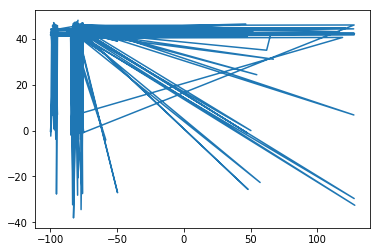

In [30]:
plt.plot(longitude, latitude);

Seems kind of wird.. I have also tried DESC and ASC:

In [31]:
longitudeDESC = %sql SELECT longitude FROM geonames ORDER BY population DESC LIMIT 1000;

1000 rows affected.


In [32]:
latitudeDESC = %sql SELECT latitude FROM geonames ORDER BY population DESC LIMIT 1000;

1000 rows affected.


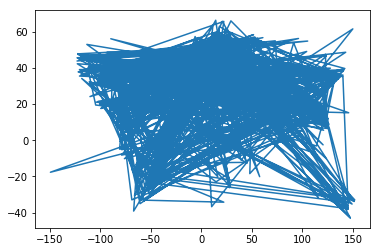

In [34]:
plt.plot(longitudeDESC, latitudeDESC);

In [35]:
longitudeASC = %sql SELECT longitude FROM geonames ORDER BY population ASC LIMIT 1000;

1000 rows affected.


In [36]:
latitudeASC = %sql SELECT latitude FROM geonames ORDER BY population ASC LIMIT 1000;

1000 rows affected.


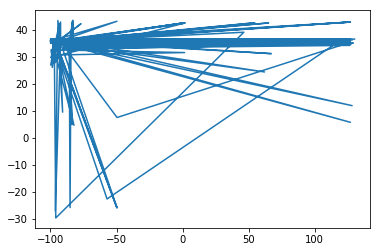

In [37]:
plt.plot(longitudeASC, latitudeASC);

2. In the second part your job is to work with JSON data from the magic schema. The schema is based on the game Magic:

A. Find all the cards that is made by Rob Alexander

Just to see what kind of information cards holds.

In [39]:
%sql SELECT data from cards limit 1;

1 rows affected.


data
"{'id': 'ab1ab474019e4e76c66e2b524d354cb7c3212616', 'cmc': 7, 'name': ""Ancestor's Chosen"", 'text': ""First strike (This creature deals combat damage before creatures without first strike.)\nWhen Ancestor's Chosen enters the battlefield, you gain 1 life for each card in your graveyard."", 'type': 'Creature — Human Cleric', 'power': '4', 'types': ['Creature'], 'artist': 'Pete Venters', 'colors': ['White'], 'flavor': '""The will of all, by my hand done.""', 'layout': 'normal', 'number': '1', 'rarity': 'Uncommon', 'manaCost': '{5}{W}{W}', 'subtypes': ['Human', 'Cleric'], 'imageName': ""ancestor's chosen"", 'mciNumber': '1', 'toughness': '4', 'multiverseid': 130550, 'colorIdentity': ['W']}"


In [50]:
%sql SELECT data -> 'name' as card FROM cards WHERE data @> '{"artist":"Rob Alexander"}' limit 10;

10 rows affected.


card
Beacon of Immortality
Kavu Climber
Llanowar Wastes
Shivan Reef
Sulfurous Springs
Treetop Village
Plains
Forest
Badlands
Lance


B. Find all the cards that have the subtype "Human"

In [60]:
%sql SELECT data -> 'name' as card FROM cards WHERE data @>'{"subtypes":["Human"]}' limit 10;

10 rows affected.


card
Ancestor's Chosen
Ballista Squad
Benalish Knight
"Cho-Manno, Revolutionary"
Field Marshal
Honor Guard
Icatian Priest
Kjeldoran Royal Guard
Loyal Sentry
Nomad Mythmaker


C. Group all the cards based on the colour. Aggregate them by counting the number of cards per colour

In [70]:
%sql SELECT data -> 'colors' as colors, count(*) FROM cards GROUP BY data -> 'colors' ORDER BY count(*);

32 rows affected.


colors,count
"['White', 'Black', 'Red', 'Green']",2
"['White', 'Blue', 'Black', 'Green']",2
"['White', 'Blue', 'Red', 'Green']",2
"['White', 'Blue', 'Black', 'Red']",2
"['Blue', 'Black', 'Red', 'Green']",3
"['White', 'Blue', 'Red']",22
"['Blue', 'Black', 'Green']",24
"['Blue', 'Red', 'Green']",25
"['White', 'Black', 'Green']",28
"['White', 'Black', 'Red']",33


In [71]:
histogram = %sql SELECT data -> 'colors' as colors, count(*) FROM cards GROUP BY data -> 'colors' ORDER BY count(*);

32 rows affected.


I should probably have used Pandas .plot.hist() to create a histogram, but I couldn't make it work...

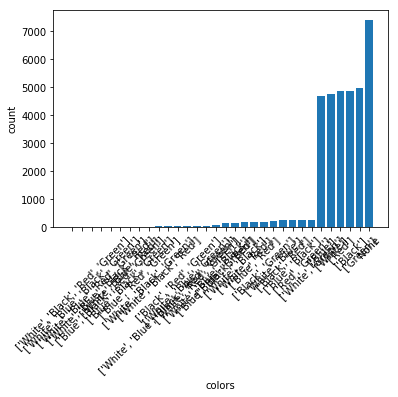

In [83]:
histogram.bar();